# CAM Combination

## Import modules

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
from typing import Union, List
from enum import Enum
import json

from PIL import Image
import numpy as np

import torch
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt

import pytorch_grad_cam as cam
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## Utils

In [3]:
class CAMType(Enum):
    GRAD_CAM = cam.GradCAM
    HI_RES_CAM = cam.HiResCAM
    GRAD_CAM_ELEMENT_WISE = cam.GradCAMElementWise
    ABLATION_CAM = cam.AblationCAM
    X_GRAD_CAM = cam.XGradCAM
    GRAD_CAM_PLUS_PLUS = cam.GradCAMPlusPlus
    SCORE_CAM = cam.ScoreCAM
    LAYER_CAM = cam.LayerCAM
    EIGEN_CAM = cam.EigenCAM
    EIGEN_GRAD_CAM = cam.EigenGradCAM
    KPCA_CAM = cam.KPCA_CAM
    RANDOM_CAM = cam.RandomCAM
    FULL_GRAD = cam.FullGrad

def get_cam(cam_type: CAMType, model: torch.nn.Module, target_layers: torch.nn.Module):
    cam_class = cam_type.value
    return cam_class(model=model, target_layers=target_layers)

def visualize(grayscale: torch.Tensor, rgb_img: np.ndarray):
    visualization = show_cam_on_image(rgb_img, grayscale, use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

def display_images_in_rows(rgb_img: np.ndarray, grayscale_list: List[torch.Tensor], labels: List[str]):
    """
    Displays a list of images in rows, with each row containing up to max_images_per_row images.
    
    Args:
        images (list of np.ndarray): List of images to display.
        labels (list of str): List of labels for each image.
        max_images_per_row (int): Maximum number of images per row (default is 4).
    """

    images = [rgb_img]

    for grayscale in grayscale_list:
        images.append(show_cam_on_image(rgb_img, grayscale, use_rgb=True))

    labels.insert(0, "Image")

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Loop through the images and labels to display them
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img)  # Show the image
        ax.set_title(label)  # Set the title
        ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

def execute_cam(
        img_path: str,
        preprocess: transforms.Compose, model: torch.nn.Module,
        target_layers: List[torch.nn.Module],
        cam_type: CAMType,
        targets: Union[List[ClassifierOutputTarget], None] = None,
        visualization: bool = False,
        output_path: Union[str, None] = None
    ):
        model_name = "unknown"
        target_layer_name = "unknown"
        try:
            model_name = model._get_name()
            target_layer_name = target_layers[0]._get_name()
        except:
            pass

        print(f"Executing CAM on {model_name} with target layer {target_layer_name}:")

        # Load the image from file
        rgb_img = Image.open(img_path).convert('RGB')

        # Apply the transformations to the image and add a batch dimension
        input_tensor = preprocess(rgb_img).unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)

        # Forward to get target class if not specified
        if not targets:
            with torch.no_grad():
                predicted_class = model(input_tensor).max(1)[-1]
                targets = [ClassifierOutputTarget(predicted_class)]
                print(f"Target class: {labels[str(predicted_class.item())][1]}")

        cam = get_cam(cam_type=cam_type, model=model, target_layers=target_layers)

        # Generate the CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  # For a single image

        # Overlay the CAM on the image
        if visualization:
            # Convert the PIL image to a NumPy array for visualization
            rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0  # Normalize the pixel values
            
            visualize(grayscale=grayscale_cam, rgb_img=rgb_img)

            # Optionally, you can save the resulting CAM visualization
            if output_path:
                Image.fromarray((visualization * 255).astype(np.uint8)).save(output_path)
                print(f"Saved output image to {output_path}")

        return grayscale_cam

labels = json.load(open("../pytorch_grad_cam/utils/imagenet_class_index.json"))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Experiments

### AlexNet

In [4]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).eval()
target_layers = [alexnet.features[10]]

Executing CAM on AlexNet with target layer Conv2d:
Target class: sulphur-crested_cockatoo
Executing CAM on AlexNet with target layer Conv2d:
Target class: sulphur-crested_cockatoo


100%|██████████| 16/16 [00:02<00:00,  7.44it/s]


Combining GradCAM++ and ScoreCAM:


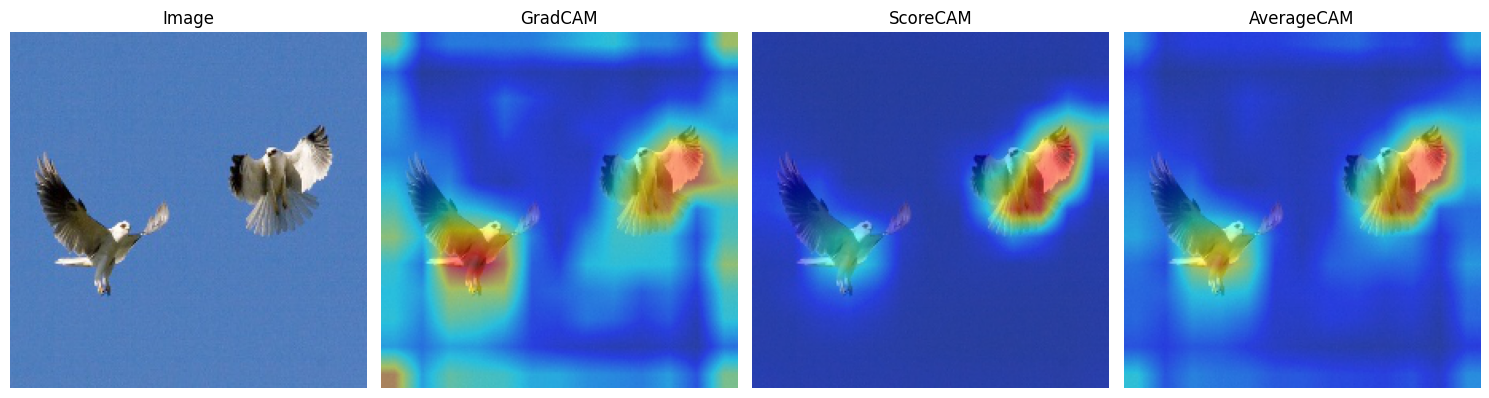

In [5]:
img_path = "../images/ILSVRC2012_val_00000073.JPEG"

grad_cam_pp = execute_cam(img_path=img_path, preprocess=transform, model=alexnet, target_layers=target_layers, cam_type=CAMType.GRAD_CAM_PLUS_PLUS)
score_cam = execute_cam(img_path=img_path, preprocess=transform, model=alexnet, target_layers=target_layers, cam_type=CAMType.SCORE_CAM)

print("Combining GradCAM++ and ScoreCAM:")
rgb_img = Image.open(img_path).convert('RGB')
rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
average_cam = (grad_cam_pp + score_cam) / 2
display_images_in_rows(rgb_img=rgb_img, grayscale_list=[grad_cam_pp, score_cam, average_cam], labels=["GradCAM", "ScoreCAM", "AverageCAM"])

Executing CAM on AlexNet with target layer Conv2d:
Target class: hare
Executing CAM on AlexNet with target layer Conv2d:
Target class: hare


100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Combining GradCAM++ and ScoreCAM:


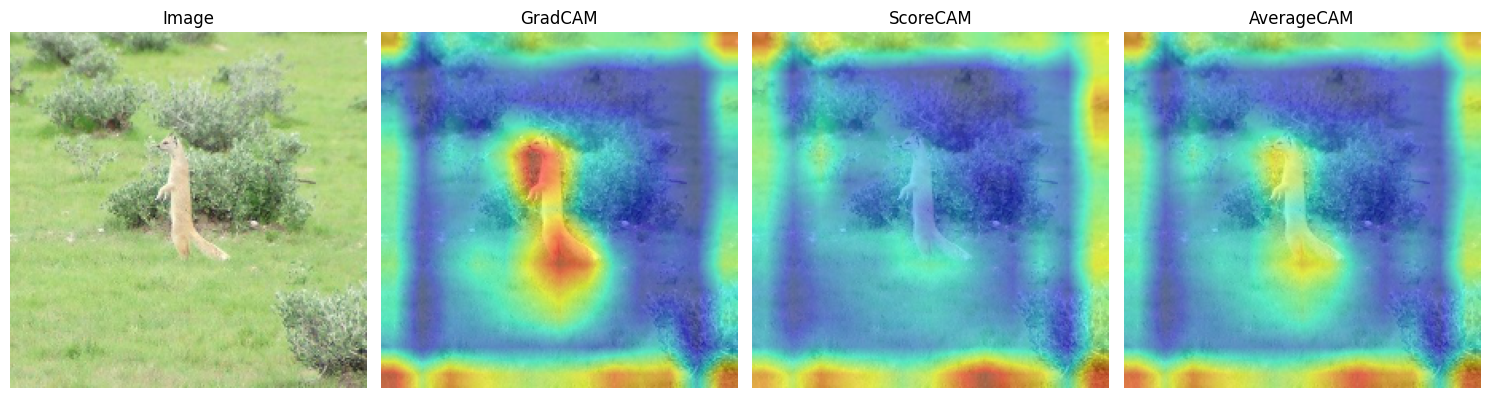

In [6]:
img_path = "../images/ILSVRC2012_val_00000518.JPEG"

grad_cam_pp = execute_cam(img_path=img_path, preprocess=transform, model=alexnet, target_layers=target_layers, cam_type=CAMType.GRAD_CAM_PLUS_PLUS)
score_cam = execute_cam(img_path=img_path, preprocess=transform, model=alexnet, target_layers=target_layers, cam_type=CAMType.SCORE_CAM)

print("Combining GradCAM++ and ScoreCAM:")
rgb_img = Image.open(img_path).convert('RGB')
rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
average_cam = (grad_cam_pp + score_cam) / 2
display_images_in_rows(rgb_img=rgb_img, grayscale_list=[grad_cam_pp, score_cam, average_cam], labels=["GradCAM", "ScoreCAM", "AverageCAM"])

Executing CAM on AlexNet with target layer Conv2d:
Target class: pedestal
Executing CAM on AlexNet with target layer Conv2d:
Target class: pedestal


100%|██████████| 16/16 [00:02<00:00,  7.50it/s]


Combining GradCAM++ and ScoreCAM:


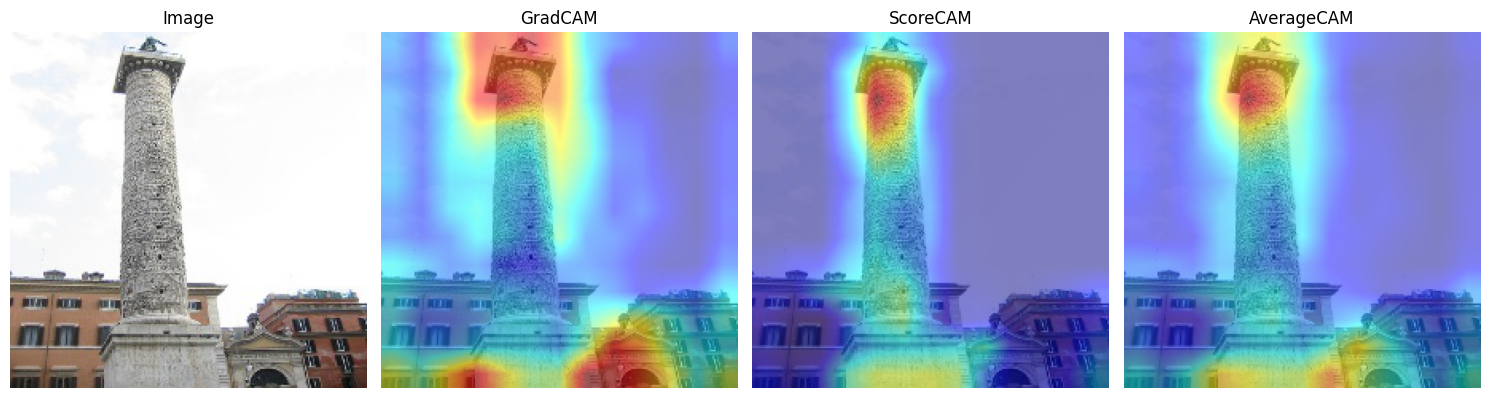

In [7]:
img_path = "../images/ILSVRC2012_val_00002193.JPEG"

grad_cam_pp = execute_cam(img_path=img_path, preprocess=transform, model=alexnet, target_layers=target_layers, cam_type=CAMType.GRAD_CAM_PLUS_PLUS)
score_cam = execute_cam(img_path=img_path, preprocess=transform, model=alexnet, target_layers=target_layers, cam_type=CAMType.SCORE_CAM)

print("Combining GradCAM++ and ScoreCAM:")
rgb_img = Image.open(img_path).convert('RGB')
rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
average_cam = (grad_cam_pp + score_cam) / 2
display_images_in_rows(rgb_img=rgb_img, grayscale_list=[grad_cam_pp, score_cam, average_cam], labels=["GradCAM", "ScoreCAM", "AverageCAM"])